Outputs
- Training set as dataframe parquet (contains image file location, ready for cvmodel inference)

In [1]:
from collections import deque
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import seaborn as sns
from typing import Deque, Dict, Any, List

In [2]:
# Characters such as empty strings '' or numpy.inf are considered NA values
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
sns.set(style="whitegrid")

In [3]:
train = pd.read_csv(f'input/train.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 84.8+ KB


In [4]:
original_len = len(train)
train.set_index(['Patient', 'Weeks'], inplace=True, drop=False)
assert original_len == len(train)
train.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1549 entries, ('ID00007637202177411956430', -4) to ('ID00426637202313170790466', 59)
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Patient        1549 non-null   object 
 1   Weeks          1549 non-null   int64  
 2   FVC            1549 non-null   int64  
 3   Percent        1549 non-null   float64
 4   Age            1549 non-null   int64  
 5   Sex            1549 non-null   object 
 6   SmokingStatus  1549 non-null   object 
dtypes: float64(1), int64(3), object(3)
memory usage: 101.6+ KB


In [5]:
train.head(20)

Patient  Weeks   FVC  \
Patient                   Weeks                                           
ID00007637202177411956430 -4     ID00007637202177411956430     -4  2315   
                           5     ID00007637202177411956430      5  2214   
                           7     ID00007637202177411956430      7  2061   
                           9     ID00007637202177411956430      9  2144   
                           11    ID00007637202177411956430     11  2069   
                           17    ID00007637202177411956430     17  2101   
                           29    ID00007637202177411956430     29  2000   
                           41    ID00007637202177411956430     41  2064   
                           57    ID00007637202177411956430     57  2057   
ID00009637202177434476278  8     ID00009637202177434476278      8  3660   
                           9     ID00009637202177434476278      9  3610   
                           11    ID00009637202177434476278     11  3895   
                           13    ID00009637202177434476278     13  3759   
                           15    ID00009637202177434476278     15  3639   
                           22    ID00009637202177434476278     22  3578   
                           33    ID00009637202177434476278     33  3625   
                           45    ID00009637202177434476278     45  3390   
                           60    ID00009637202177434476278     60  3214   
ID00010637202177584971671  0     ID00010637202177584971671      0  3523   
                           1     ID00010637202177584971671      1  3373   

                                   Percent  Age   Sex SmokingStatus  
Patient                   Weeks                                      
ID00007637202177411956430 -4     58.253649   79  Male     Ex-smoker  
                           5     55.712129   79  Male     Ex-smoker  
                           7     51.862104   79  Male     Ex-smoker  
                           9     53.950679   79  Male     Ex-smoker  
                           11    52.063412   79  Male     Ex-smoker  
                           17    52.868646   79  Male     Ex-smoker  
                           29    50.327126   79  Male     Ex-smoker  
                           41    51.937594   79  Male     Ex-smoker  
                           57    51.761449   79  Male     Ex-smoker  
ID00009637202177434476278  8     85.282878   69  Male     Ex-smoker  
                           9     84.117812   69  Male     Ex-smoker  
                           11    90.758691   69  Male     Ex-smoker  
                           13    87.589710   69  Male     Ex-smoker  
                           15    84.793550   69  Male     Ex-smoker  
                           22    83.372169   69  Male     Ex-smoker  
                           33    84.467332   69  Male     Ex-smoker  
                           45    78.991518   69  Male     Ex-smoker  
                           60    74.890484   69  Male     Ex-smoker  
ID00010637202177584971671  0     94.724672   60  Male     Ex-smoker  
                           1     90.691547   60  Male     Ex-smoker

In [6]:
pids = train['Patient'].unique()
print(f'len(pids)={len(pids)}')

len(pids)=176


<AxesSubplot:>

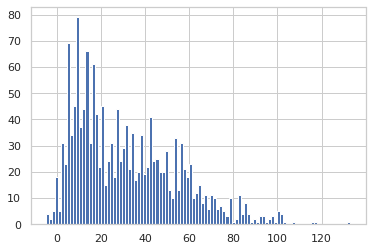

In [7]:
train['Weeks'].hist(bins=100)

In [8]:
train['Weeks'].describe()

count    1549.000000
mean       31.861846
std        23.247550
min        -5.000000
25%        12.000000
50%        28.000000
75%        47.000000
max       133.000000
Name: Weeks, dtype: float64

<AxesSubplot:>

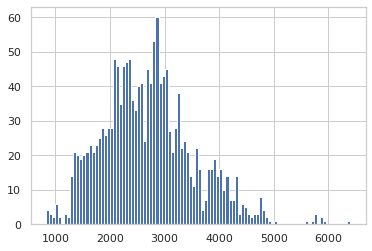

In [9]:
train['FVC'].hist(bins=100)

In [10]:
train['FVC'].describe()

count    1549.000000
mean     2690.479019
std       832.770959
min       827.000000
25%      2109.000000
50%      2641.000000
75%      3171.000000
max      6399.000000
Name: FVC, dtype: float64

In [11]:
blacklist = {'ID00011637202177653955184', 'ID00052637202186188008618'}
train = train.query('Patient not in @blacklist')
assert len(train.Patient.unique()) == 174

# Get last three FVC readings per patient

Add the features extracted from images e.g. lung area, tissue area

In [12]:
imf = pd.read_parquet(f'input/processed/imf.parquet')
imf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32684 entries, 0 to 32683
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   img          32684 non-null  object
 1   lung_area    32684 non-null  int64 
 2   tissue_area  32684 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 766.2+ KB


In [13]:
def explode(row: Dict[str, Any]) -> List[Dict[str, Any]]:
    res: List[Dict[str, Any]] = []
    pid = row['pid']
    path = f'input/processed/{pid}'
    for filename in os.listdir(path):
        r = dict(row)
        r['img'] = f'{pid}/{filename}'
        res.append(r)
    return res


def set_last_visits(
    row: Dict[str, Any], 
    last_weeks: Deque[int],
    last_fvc: Deque[float]
) -> None:
    if len(last_fvc) == 0:
        raise ValueError('there should be at least one fvc reading per patient')
    elif len(last_fvc) == 1:
        last_fvc.append(last_fvc[0])
        last_fvc.append(last_fvc[0])
    elif len(last_fvc) == 2:
        last_fvc.append(last_fvc[1])
    elif len(last_fvc) > 3:
        raise ValueError('get last 3 fvc readings per patient')
    if len(last_weeks) == 0:
        raise ValueError('there should be at least one week number per patient')
    elif len(last_weeks) == 1:
        last_weeks.append(last_weeks[0])
        last_weeks.append(last_weeks[0])
    elif len(last_weeks) == 2:
        last_weeks.append(last_weeks[1])
    elif len(last_weeks) > 3:
        raise ValueError('get last 3 fvc readings per patient')
    row['fvc_last_1'] = last_fvc[2]
    row['fvc_last_2'] = last_fvc[1]
    row['fvc_last_3'] = last_fvc[0]
    row['week_last_1'] = last_weeks[2]
    row['week_last_2'] = last_weeks[1]
    row['week_last_3'] = last_weeks[0]




rows = []
row: Dict[str, Any] = {}
prev = None
last_weeks: Deque[int] = deque()
last_fvc: Deque[float] = deque()
for t in train.itertuples():
    # new patient
    if prev is not None and prev != t.Patient:
        set_last_visits(row, last_weeks, last_fvc)
        rows += explode(row)
    if prev is None or prev != t.Patient:
        row = {}
        last_weeks = deque()
        last_fvc = deque()
        row['pid'] = t.Patient
        row['age'] = t.Age
        row['sex'] = t.Sex
        row['smoking'] = t.SmokingStatus
        row['week_1'] = t.Weeks
        row['fvc_1'] = t.FVC
        row['percent_1'] = t.Percent
    prev = t.Patient
    last_weeks.append(t.Weeks)
    if len(last_weeks) == 4:
        last_weeks.popleft()
    last_fvc.append(t.FVC)
    if len(last_fvc) == 4:
        last_fvc.popleft()
    

# add the last patient!
if len(row) != 0:
    set_last_visits(row, last_weeks, last_fvc)
    rows += explode(row)

    

train = pd.DataFrame.from_records(rows)
assert len(train) == len(imf)
train.set_index(['img'], drop=False, inplace=True)
train.sort_index(inplace=True)
imf.set_index(['img'], drop=False, inplace=True)
imf.sort_index(inplace=True)
assert train.iloc[0]['img'] == imf.iloc[0]['img'] 
train['lung_area'] = imf['lung_area']
train['tissue_area'] = imf['tissue_area']
train['lung_tissue_ratio'] = train['lung_area'] / train['tissue_area']
train = train.astype({
    'pid': str,
    'img': str,
    'age': np.uint8,
    'sex': str,
    'smoking': str,
    'week_1': np.int16,
    'fvc_1': np.uint16,
    'percent_1': np.float32,
    'fvc_last_1': np.uint16,
    'fvc_last_2': np.uint16,
    'fvc_last_3': np.uint16,
    'week_last_1': np.int16,
    'week_last_2': np.int16,
    'week_last_3': np.int16,
    'lung_area': np.uint32,
    'tissue_area': np.uint32,
    'lung_tissue_ratio': np.float32
})
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32684 entries, ID00007637202177411956430/1.png to ID00426637202313170790466/99.png
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pid                32684 non-null  object 
 1   age                32684 non-null  uint8  
 2   sex                32684 non-null  object 
 3   smoking            32684 non-null  object 
 4   week_1             32684 non-null  int16  
 5   fvc_1              32684 non-null  uint16 
 6   percent_1          32684 non-null  float32
 7   fvc_last_1         32684 non-null  uint16 
 8   fvc_last_2         32684 non-null  uint16 
 9   fvc_last_3         32684 non-null  uint16 
 10  week_last_1        32684 non-null  int16  
 11  week_last_2        32684 non-null  int16  
 12  week_last_3        32684 non-null  int16  
 13  img                32684 non-null  object 
 14  lung_area          32684 non-null  uint32 
 15  tissue_area       

In [14]:
train.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,img,lung_area,tissue_area,lung_tissue_ratio
img,,,,,,,,,,,,,,,,,
ID00007637202177411956430/1.png,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/1.png,1149,6314,0.181977
ID00007637202177411956430/10.png,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/10.png,2691,6016,0.447307
ID00007637202177411956430/11.png,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/11.png,2502,5735,0.436269
ID00007637202177411956430/12.png,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/12.png,1102,8082,0.136352
ID00007637202177411956430/13.png,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/13.png,2413,5101,0.473045


In [15]:
train['lung_area'].describe()

count    32684.000000
mean      1923.789652
std       1239.577675
min          0.000000
25%        942.750000
50%       1727.000000
75%       2576.000000
max       7873.000000
Name: lung_area, dtype: float64

In [16]:
train['tissue_area'].describe()

count    32684.00000
mean      7099.51233
std       4033.61665
min          0.00000
25%       3786.00000
50%       6327.50000
75%       9689.00000
max      25645.00000
Name: tissue_area, dtype: float64

In [17]:
train['lung_tissue_ratio'].describe()

count    32683.000000
mean         1.526937
std          8.181928
min          0.012104
25%          0.122620
50%          0.280338
75%          0.524516
max        125.057144
Name: lung_tissue_ratio, dtype: float64

In [28]:
groups = train.groupby(['pid']).min()

In [29]:
groups['week_1'].describe()

count    174.000000
mean      14.218391
std       15.162263
min       -5.000000
25%        3.000000
50%        9.000000
75%       21.750000
max       79.000000
Name: week_1, dtype: float64

In [30]:
groups['week_last_3'].describe()

count    174.000000
mean      39.862069
std       16.853104
min        8.000000
25%       29.000000
50%       34.000000
75%       49.000000
max      104.000000
Name: week_last_3, dtype: float64

In [31]:
groups['week_last_2'].describe()

count    174.000000
mean      51.902299
std       17.602768
min       10.000000
25%       41.000000
50%       46.500000
75%       61.750000
max      117.000000
Name: week_last_2, dtype: float64

In [32]:
groups['week_last_1'].describe()

count    174.000000
mean      66.816092
std       17.240246
min       29.000000
25%       57.000000
50%       62.000000
75%       75.750000
max      133.000000
Name: week_last_1, dtype: float64

In [33]:
groups['fvc_1'].describe()

count     174.000000
mean     2770.183908
std       839.056607
min      1015.000000
25%      2225.000000
50%      2665.000000
75%      3238.500000
max      6399.000000
Name: fvc_1, dtype: float64

In [34]:
groups['fvc_last_1'].describe()

count     174.000000
mean     2530.166667
std       833.305009
min       828.000000
25%      1905.250000
50%      2471.500000
75%      2970.250000
max      5768.000000
Name: fvc_last_1, dtype: float64

In [35]:
groups['fvc_last_2'].describe()

count     174.000000
mean     2585.729885
std       847.379089
min       827.000000
25%      2032.250000
50%      2504.500000
75%      2990.500000
max      5895.000000
Name: fvc_last_2, dtype: float64

In [36]:
groups['fvc_last_3'].describe()

count     174.000000
mean     2648.482759
std       829.199389
min       974.000000
25%      2079.250000
50%      2576.000000
75%      3060.750000
max      5613.000000
Name: fvc_last_3, dtype: float64

In [37]:
train.to_parquet('output/train.parquet', index=False)